In [1]:
import pandas as pd
import numpy as np
import sklearn as sklearn 
import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Import dataset
df = pd.read_csv(r'C:\Users\Yuva S Korlaband\Documents\CCA Model Weekly\carbon_subset_Weekly_df.csv')

# Drop unnecessary columns
cols_to_drop = [
    'index',  'Benchmark', 'Front_Weekly_min', 'Front_Weekly_max',
    'CA_Mean', 'CA_Median', 'CA_Percent Above Floor', 'CA_Median allowance price',
    'AA_Maximum', 'CA_Clearing Price', 'AA_Mean', 'AA_Median', 'CA_Maximum',
    'CA_Cleared Above Floor', 'AA_Median allowance price', 'AA_Floor Price',
    'AA_Clearing Price', 'CA_Vintage', 'AA_Percent above Floor',
    'AA_Cleared Above Floor', 'CA_Minimum', 'CA_Floor Price', 'AA_Vintage'
]
df.drop(cols_to_drop, axis=1, inplace=True)

# Define target (Y) and feature column (X) names
target_col = ['Front', 'date']
feature_cols = df.columns.difference(target_col).tolist()

df_target = df[target_col]
df_features = df[feature_cols]

# DateTime encoding
df_target['date'] = pd.to_datetime(df_target['date']).dt.strftime('%Y-%m-%d').astype(str)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 69 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   date                                                                                           375 non-null    object 
 1   8 Open_Interest_All                                                                            375 non-null    float64
 2   9 Prod_Merc_Positions_Long_All                                                                 375 non-null    float64
 3   10 Prod_Merc_Positions_Short_All                                                               375 non-null    float64
 4   11 Swap_Positions_Long_All                                                                     375 non-null    float64
 5   12 Swap__Positions_Sho

In [5]:
# create columns of lag observations
df_target['Target_Price+4'] = df_target['Front'].shift(-4)
df_target['Target_Price+12'] = df_target['Front'].shift(-12)
df_target['Target_Price+52'] = df_target['Front'].shift(-52)
df_target['Date+4'] = df_target['date'].shift(-4)
df_target['Date+12'] = df_target['date'].shift(-12)
df_target['Date+52'] = df_target['date'].shift(-52)

In [6]:
def get_time_lag(time_lag_in_weeks, date):
    d = datetime.datetime.strptime(date, '%Y-%m-%d')
    d2 = d + relativedelta(days=7*time_lag_in_weeks)
    print(str(d2)[0:10])
    return str(d2)[0:10]


In [7]:
# forward fill new date columns
def ffill_dates(datename, startdate, time_lag): 
    df_target[datename] = pd.to_datetime(df_target[datename])
    enddate = get_time_lag(time_lag, '2023-04-01')
    fill_vals = pd.date_range(start='2023-04-02', end=enddate, freq='W-TUE').strftime('%Y-%m-%d').tolist()
    df_target[datename][df_target.shape[0]-time_lag:] = fill_vals
    df_target[datename] = df_target[datename].dt.strftime('%Y-%m-%d').astype(str)
    #print(df_target)
    return df_target


df_target = ffill_dates('Date+4', df_target['Date+4'][0], 4)
df_target = ffill_dates('Date+12', df_target['Date+12'][0], 12)
df_target = ffill_dates('Date+52', df_target['Date+52'][0], 52)


# features and target df
df = pd.concat([df_target, df_features], axis=1)

2023-04-29
2023-06-24
2024-03-30


In [9]:
#Date time features

df['date'] = pd.to_datetime(df['date'])
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
#df['week'] = df['date'].dt.week
df['weekday'] = df['date'].dt.weekday

In [10]:
def lag_features(df, col, weeks):
    return df[col].shift(weeks)

Monthly decomposition


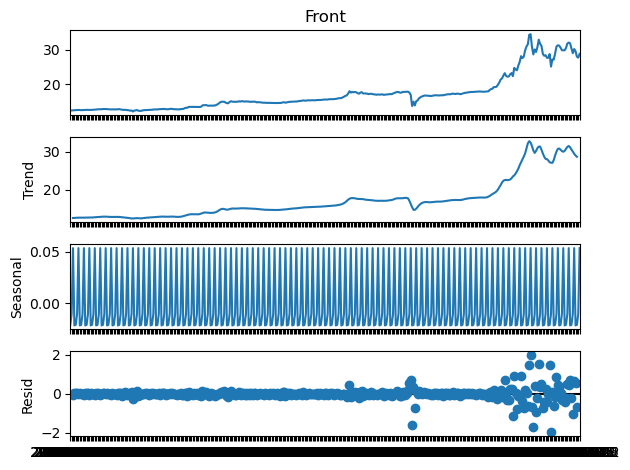



Quarterly decomposition


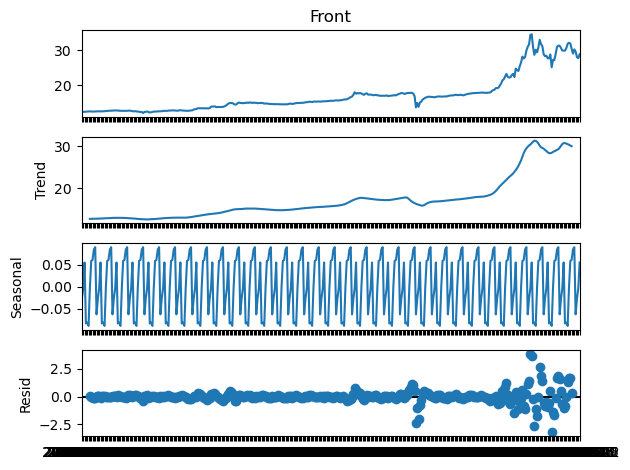

In [11]:
#Seasonality features
# seasonal decomposition

df_datetime_idx = df_target[['date', 'Front']].set_index('date')

# Create additive seasonal decomposition
result_add_4 = seasonal_decompose(df_datetime_idx['Front'], model='additive', period=4)
result_add_12 = seasonal_decompose(df_datetime_idx['Front'], model='additive', period=12)

# Plot
print('Monthly decomposition')
fig = result_add_4.plot()
plt.show()

print('\n')
print('Quarterly decomposition')
fig = result_add_12.plot()
plt.show()

In [13]:
def add_decompose_features(df, col, series):
    df[col] = series.values
    return df[col].fillna(method='bfill').fillna(method='ffill')


df_features['trend_4'] = add_decompose_features(df_features, 'trend_4', result_add_4.trend)
df_features['seasonal_4'] = add_decompose_features(df_features, 'seasonal_4', result_add_4.seasonal)
df_features['resid_4'] = add_decompose_features(df_features, 'resid_4', result_add_4.resid)
#df_features['observed_3'] = add_decompose_features(df_features, 'observed_3', result_add_3.observed)

df_features['trend_12'] = add_decompose_features(df_features, 'trend_12', result_add_12.trend)
df_features['seasonal_12'] = add_decompose_features(df_features, 'seasonal_12', result_add_12.seasonal)
df_features['resid_12'] = add_decompose_features(df_features, 'resid_12', result_add_12.resid)
#df_features['observed_12'] = add_decompose_features(df_features, 'observed_12', result_add_12.observed)


In [14]:
auct_months = [2, 5, 8, 11]
df['auction_idx'] = np.where(df['month'].isin(auct_months), 1, 0)

In [21]:
df.to_csv(r'C:\Users\Yuva S Korlaband\Documents\worked.csv')

In [15]:
remove_feature_cols = ([target_col[0], target_col[1], 'date', 'Target_Price+4', 'Target_Price+12','Target_Price+52', 
                        'Date+4', 'Date+12', 'Date+52'])

feature_cols = [i for i in list(df.columns) if i not in remove_feature_cols]

In [16]:

def split_by_idx(row_limit):
    test_set_idx = list(range(4,100,10))
    X_train = df[feature_cols][~df.index.isin(test_set_idx)][:row_limit] 
    X_test = df[feature_cols][df.index.isin(test_set_idx)][:row_limit]
    y_train = df[target_col[0]][~df.index.isin(test_set_idx)][:row_limit]
    y_test = df[target_col[0]][df.index.isin(test_set_idx)][:row_limit]
    return X_train, y_train, X_test, y_test


# prediction horizon: 1 month
X_train1, y_train1, X_test1, y_test1 = split_by_idx(df[feature_cols].shape[0]-4)

# prediction horizon: 3 months
X_train2, y_train2, X_test2, y_test2 = split_by_idx(df[feature_cols].shape[0]-12)

# prediction horizon: 12 months
X_train3, y_train3, X_test3, y_test3 = split_by_idx(df[feature_cols].shape[0]-52)

In [17]:
# based on the univariate statistical test... for supervised learning

def select_features(X_train, y_train, X_test, N_KBest):
    if N_KBest is None:
        fs = SelectKBest(score_func=f_regression, k='all')
        #fs = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs = SelectKBest(score_func=f_regression, k=N_KBest)
        #fs = SelectKBest(score_func=mutual_info_regression, k=N_KBest)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 

X_train_fs1, X_test1_fs, fs1 = select_features(X_train1, y_train1, X_test1, None)
X_train_fs2, X_test2_fs, fs2 = select_features(X_train2, y_train2, X_test2, None)
X_train_fs3, X_test3_fs, fs3 = select_features(X_train3, y_train3, X_test3, None)


def get_KBest(X_train, fs):
# what are scores for the features
    KBest_cols = []
    for i in range(len(fs.scores_)):
        if fs.scores_[i] >= 5:
        #print(X_train1.columns[i]+':', fs.scores_[i])
            KBest_cols.append(X_train.columns[i]) 
            
    N_KBest = len(KBest_cols)
    return KBest_cols, N_KBest


KBest_cols1, N_KBest1 = get_KBest(X_train1, fs1)
KBest_cols2, N_KBest2 = get_KBest(X_train2, fs2)
KBest_cols3, N_KBest3 = get_KBest(X_train3, fs3)


X_train_fs1, X_test1_fs, fs1 = select_features(X_train1, y_train1, X_test1, N_KBest1)
X_train_fs2, X_test2_fs, fs2 = select_features(X_train2, y_train2, X_test2, N_KBest2)
X_train_fs3, X_test3_fs, fs3 = select_features(X_train3, y_train3, X_test3, N_KBest3)


# plot the scores
#pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
#pyplot.show()

In [18]:
# scaling 

def scale_inputs(X_train, X_test, X_pred):
    scaler = StandardScaler().fit(X_train)
    train_sc = scaler.transform(X_train)
    test_sc = scaler.transform(X_test)
    pred_sc = scaler.transform(X_pred)
    
    return train_sc, test_sc, pred_sc


n_rows1 = df[KBest_cols1].shape[0]
X_pred1 = df[KBest_cols1][(n_rows1-4):n_rows1] 
#X_train1, X_test1, X_pred1 = scale_inputs(X_train1, X_test1, X_pred1)

X_pred2 = df[KBest_cols2][(n_rows1-12):n_rows1] 
#X_train2, X_test2, X_pred2 = scale_inputs(X_train2, X_test2, X_pred2)

X_pred3 = df[KBest_cols3][(n_rows1-52):n_rows1]
#X_train3, X_test3, X_pred3 = scale_inputs(X_train3, X_test3, X_pred3)


In [19]:
#random forest

def get_best_params(X_train, y_train):

    clf_rfg = RandomForestRegressor(random_state=42)
    
    param_grid = { 
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [2,6,8],
        "min_samples_split" : [2,4,8],
        'bootstrap': [True, False]}
    
    CV_rfc = GridSearchCV(estimator=clf_rfg, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    
    return CV_rfc.best_params_


#best_params1 = get_best_params(X_train1, y_train1)
best_params1_rfg = get_best_params(X_train_fs1, y_train1)

#best_params2 = get_best_params(X_train2, y_train2)
best_params2_rfg = get_best_params(X_train_fs2, y_train2)

#best_params3 = get_best_params(X_train3, y_train3)
best_params3_rfg = get_best_params(X_train_fs3, y_train3)
